In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error as mse

In [2]:
cpi_train = pd.read_csv('CPI_train.csv')

In [3]:
cpi_train # 124 rows * 2 columns

,Quarter,CPI
0,1990-03-01,43.513571
1,1990-06-01,43.993571
2,1990-09-01,44.593571
3,1990-12-01,46.633571
4,1991-03-01,48.673571
...,...,...
119,2019-12-01,165.313571
120,2020-03-01,168.073571
121,2020-06-01,167.713571
122,2020-09-01,167.473571


In [4]:
cpi_train['Quarter'] = pd.to_datetime(cpi_train['Quarter']) # convert the data in Quarter column to datetime
cpi_train.set_index('Quarter',inplace=True) # index data frame by Quarter column
cpi_train

,CPI
Quarter,
1990-03-01,43.513571
1990-06-01,43.993571
1990-09-01,44.593571
1990-12-01,46.633571
1991-03-01,48.673571
...,...
2019-12-01,165.313571
2020-03-01,168.073571
2020-06-01,167.713571


## EDA

In [5]:
cpi_train.isna().sum() # check missing value

CPI    0
dtype: int64

In [6]:
cpi_train.describe().round(3) # check statistics

,CPI
count,124.000
mean,97.997
std,37.232
min,43.514
25%,67.124
50%,89.234
75%,129.404
max,169.634


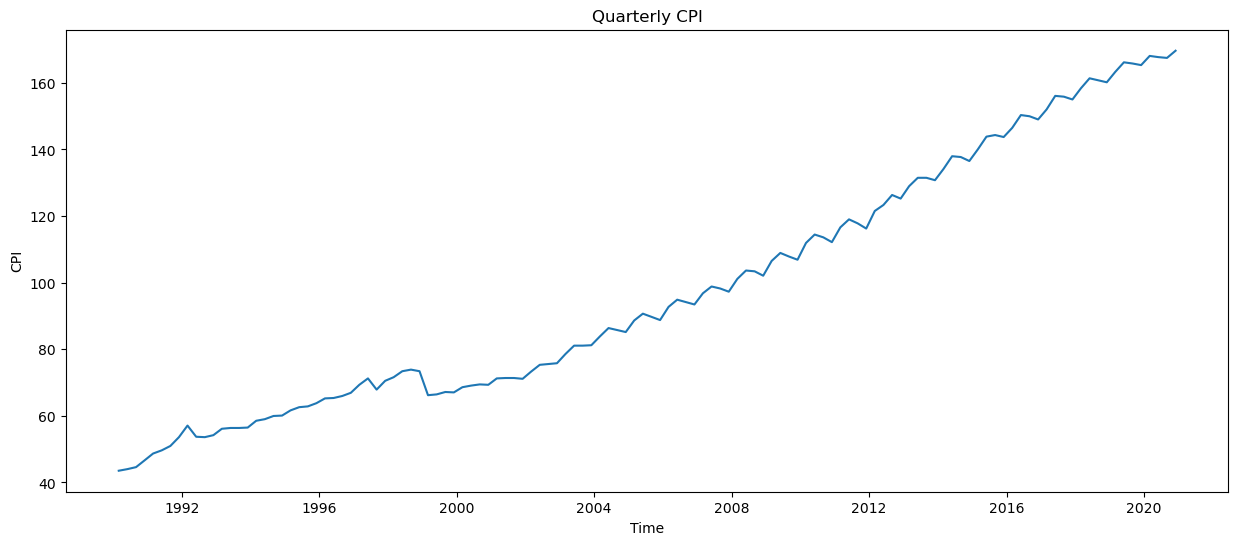

In [7]:
ts=cpi_train['CPI'] # extract CPI column
# time series plot, plot CPI over time
plt.figure(figsize=(15,6))
plt.plot(ts.index,ts)
plt.xlabel('Time')
plt.ylabel('CPI')
plt.title('Quarterly CPI')
plt.show()

describe the time series plot\
trend: growing trend\
cycle:\
seasonality: shows seasonality (m=4) starting from 2001/12/1\
noise:

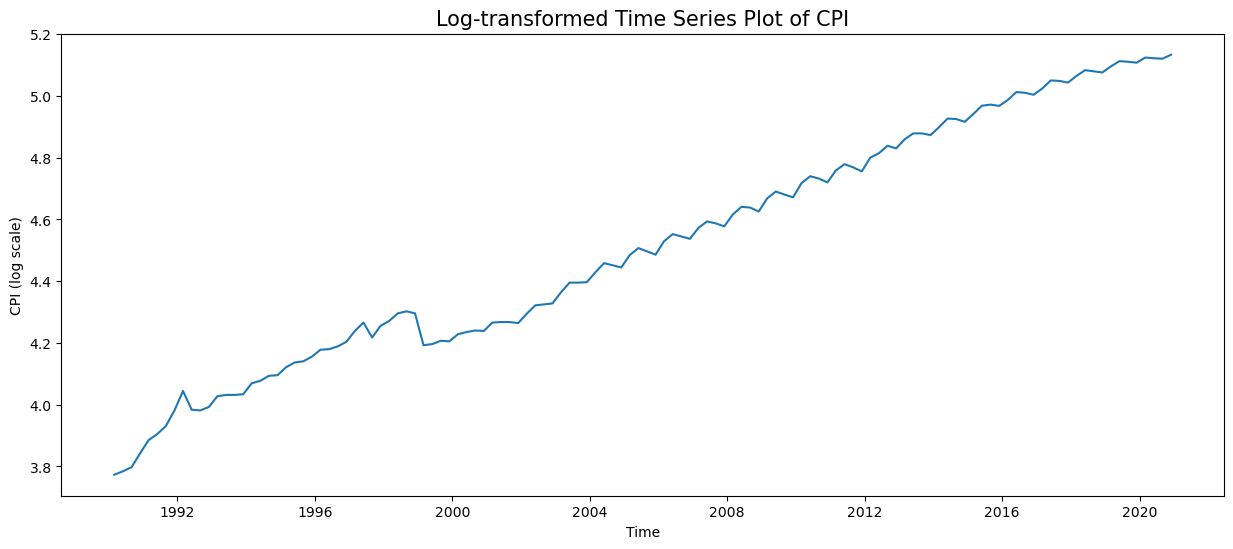

In [8]:
# apply log transformation
ts_log=np.log(ts)
# log-transformed time series plot
plt.figure(figsize=(15,6))
plt.plot(ts.index,ts_log)
plt.title('Log-transformed Time Series Plot of CPI',fontsize=15)
plt.xlabel('Time')
plt.ylabel('CPI (log scale)')
plt.show()
# log trasnformation convert multiplicative to additive, our plot is clearly additive, there is no need for log transformation, therefore original data will be used

In [9]:
trend_CMA4 = ts.rolling(4,center=True).mean().rolling(2,center=True).mean().shift(-1) # use CMA-4 to reveal trend component

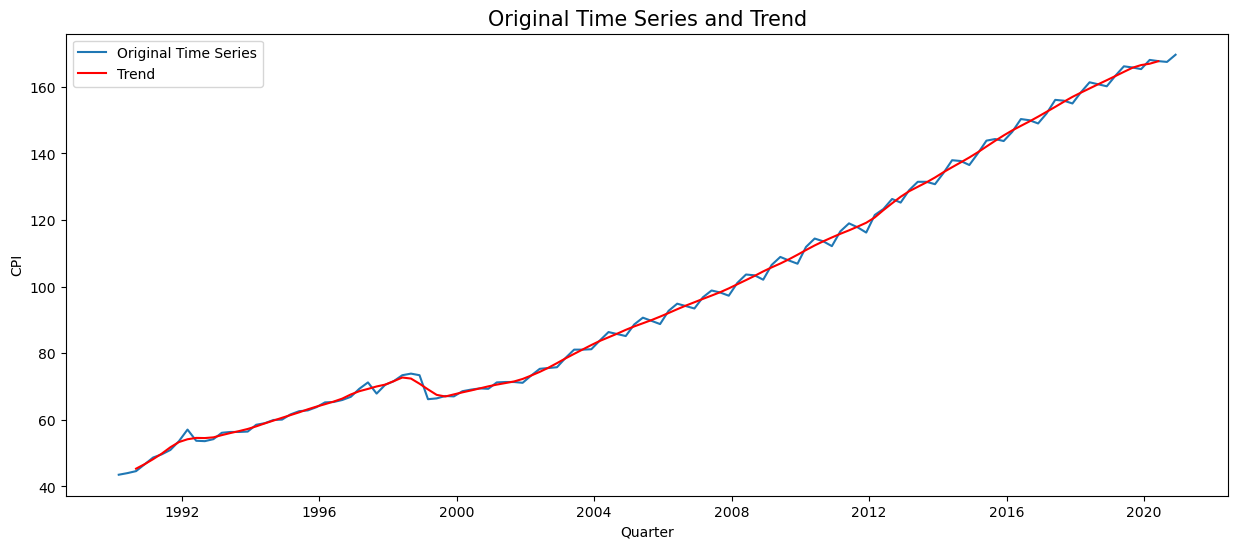

In [10]:
plt.figure(figsize=(15,6))
plt.plot(ts.index,ts,label='Original Time Series')
plt.plot(ts.index,trend_CMA4,'r-',label='Trend')
plt.xlabel('Quarter')
plt.ylabel('CPI')
plt.title('Original Time Series and Trend',fontsize=15)
plt.legend()
plt.show() # plot trend (CMA-4 reveal trend and cycle, smooth out seasonality and noise)

from time series plot, we can tell that additive method should be used

## train set and validation set

there are 8 data in CPI_test\
we do the same for validation set\
CPI_train have 124 rows in total\
therefore we split it as 116 for training set and 8 for validation set

In [11]:
ts_train=ts[:-8]
ts_validation=ts[-8:]

In [12]:
ts_train.shape # 116 rows

(116,)

In [13]:
ts_validation.shape # 8 rows

(8,)

## Neural Networks I (Yi Liu)

In [14]:
# ! pip install --upgrade pip
# ! pip install tensorflow           

In [15]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import tensorflow as tf

In [16]:
# Use the following code to control the randomness in building NN
# reference: https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
import random as python_random

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(0)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(0)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(0)

In [17]:
# Convert data from DataFrame to array
ts_train_not_scaled = ts_train.values  # Convert from DataFrame to Python Array
ts_train_not_scaled = ts_train_not_scaled.astype('float')  # You need to make sure the data is of type float
ts_train_not_scaled = ts_train_not_scaled.reshape(len(ts_train_not_scaled), 1)  # Reshape

# Same for validation set
ts_validation_not_scaled = ts_validation.values  # Convert from DataFrame to Python Array
ts_validation_not_scaled = ts_validation_not_scaled.astype('float')  # You need to make sure the data is of type float
ts_validation_not_scaled = ts_validation_not_scaled.reshape(len(ts_validation_not_scaled), 1)  

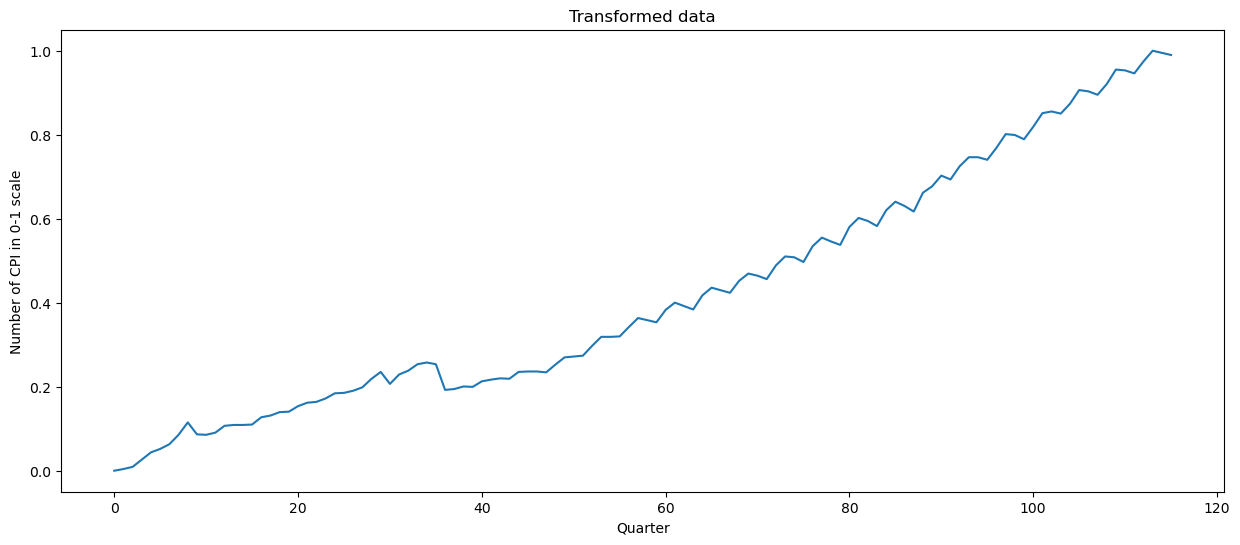

In [18]:
# Time window to define the number of features in each row
time_window = 12

# Define a scaler object
scaler = MinMaxScaler(feature_range=(0, 1))

# Compute in-sample and out-of-sample size
#train_size = len(ts_train)
#test_size = len(ts_validation)

# Fitting the scaler on training data
fitted_transformer = scaler.fit(ts_train_not_scaled)

# Transforming using the trained scaler
ts_train_scaled = fitted_transformer.transform(ts_train_not_scaled)
ts_validation_scaled = fitted_transformer.transform(ts_validation_not_scaled)

train_index = np.arange(len(ts_train_scaled))

# Plot the scaled data
plt.figure(figsize=(15,6))
plt.plot(train_index,ts_train_scaled)
plt.xlabel('Quarter')
plt.ylabel('Number of CPI in 0-1 scale')
plt.title('Transformed data')
plt.show()

In [19]:
# Pre-allocation
Xall, Yall = [], []
Xall_not_scaled, Yall_not_scaled = [], []

# Use each rolling window as a row in the data matrix 
for i in range(time_window, len(ts_train_scaled)):
    Xall.append(ts_train_scaled[i-time_window:i, 0]) # Access the accuracy
    Xall_not_scaled.append(ts_train_not_scaled[i-time_window:i, 0]) # Training NN
    Yall.append(ts_train_scaled[i, 0])
    Yall_not_scaled.append(ts_train_not_scaled[i, 0])

# Convert them from list to numpy array
Xall = np.array(Xall)
Yall = np.array(Yall)
Xall_not_scaled = np.array(Xall_not_scaled)
Yall_not_scaled = np.array(Yall_not_scaled)

# Training data
Xtrain = Xall
Ytrain = Yall

# Test data
Xtest = ts_validation_scaled[:-time_window+1]
Ytest = ts_validation_scaled[-time_window+1:]

In [20]:
model_ffnn = Sequential()
model_ffnn.add(Dense(10, input_dim = time_window, activation='relu'))
model_ffnn.add(Dense(1))

In [21]:
model_ffnn.compile(loss='mean_squared_error', optimizer='adam')

In [22]:
model_ffnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                130       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________


In [23]:
model_ffnn.fit(Xtrain, Ytrain, epochs=300, batch_size=20 , verbose=1)

Epoch 1/300
6/6 [==============================] - 0s 2ms/step - loss: 1.3513
Epoch 2/300
6/6 [==============================] - 0s 2ms/step - loss: 1.1427
Epoch 3/300
6/6 [==============================] - 0s 2ms/step - loss: 0.9742
Epoch 4/300
6/6 [==============================] - 0s 2ms/step - loss: 0.8146
Epoch 5/300
6/6 [==============================] - 0s 2ms/step - loss: 0.6772
Epoch 6/300
6/6 [==============================] - 0s 2ms/step - loss: 0.5683
Epoch 7/300
6/6 [==============================] - 0s 2ms/step - loss: 0.4793
Epoch 8/300
6/6 [==============================] - 0s 2ms/step - loss: 0.4111
Epoch 9/300
6/6 [==============================] - 0s 2ms/step - loss: 0.3512
Epoch 10/300
6/6 [==============================] - 0s 2ms/step - loss: 0.2999
Epoch 11/300
6/6 [==============================] - 0s 2ms/step - loss: 0.2559
Epoch 12/300
6/6 [==============================] - 0s 2ms/step - loss: 0.2166
Epoch 13/300
6/6 [==============================] - 0s 2ms/st

6/6 [==============================] - 0s 2ms/step - loss: 7.4680e-04
Epoch 205/300
6/6 [==============================] - 0s 1ms/step - loss: 7.4431e-04
Epoch 206/300
6/6 [==============================] - 0s 1ms/step - loss: 7.4087e-04
Epoch 207/300
6/6 [==============================] - 0s 1ms/step - loss: 7.3641e-04
Epoch 208/300
6/6 [==============================] - 0s 1ms/step - loss: 7.3295e-04
Epoch 209/300
6/6 [==============================] - 0s 1ms/step - loss: 7.2865e-04
Epoch 210/300
6/6 [==============================] - 0s 1ms/step - loss: 7.2545e-04
Epoch 211/300
6/6 [==============================] - 0s 2ms/step - loss: 7.2449e-04
Epoch 212/300
6/6 [==============================] - 0s 1ms/step - loss: 7.2069e-04
Epoch 213/300
6/6 [==============================] - 0s 1ms/step - loss: 7.1771e-04
Epoch 214/300
6/6 [==============================] - 0s 2ms/step - loss: 7.1693e-04
Epoch 215/300
6/6 [==============================] - 0s 2ms/step - loss: 7.1382e-04
Epoch 

1/1 [==============================] - 0s 17ms/step


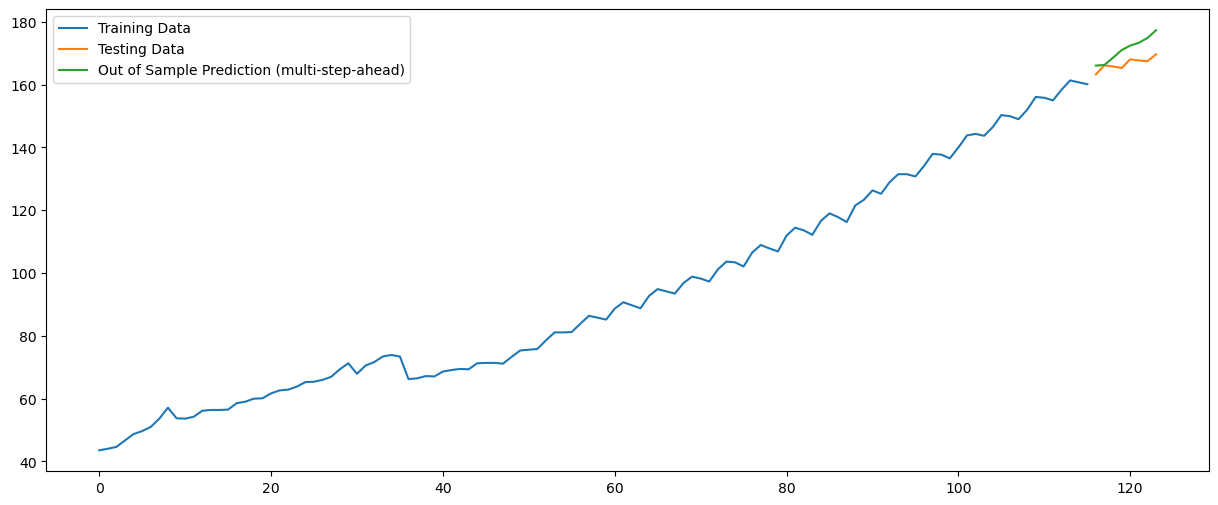

Dynamic Forecast MSE: 0.0162


In [24]:
#Dynamical Prediction
dynamic_prediction = np.copy(ts_train_scaled[-time_window:])

for i in range(len(ts_validation_scaled)):
    last_feature = np.reshape(dynamic_prediction[i:i+time_window], (1, time_window, 1))
    next_pred = model_ffnn.predict(last_feature)
    dynamic_prediction = np.append(dynamic_prediction, next_pred)

# Transform forecast values to original scale
dynamic_prediction = dynamic_prediction.reshape(-1, 1)
dynamic_prediction_original_scale = fitted_transformer.inverse_transform(dynamic_prediction)

# Plot
test_index = np.arange(len(ts_train_scaled), len(ts_train_scaled) + len(ts_validation_scaled))

plt.figure(figsize=(15, 6))
plt.plot(ts_train_not_scaled, label='Training Data')
plt.plot(test_index, ts_validation_not_scaled, label='Testing Data')
plt.plot(test_index, dynamic_prediction_original_scale[time_window:], label='Out of Sample Prediction (multi-step-ahead)')
plt.legend(loc="upper left")
plt.show()
# Compute MSE score on test data
test_mse = mean_squared_error(Ytest, dynamic_prediction[:len(Ytest)])
print('Dynamic Forecast MSE: {0:.4f}'.format(test_mse))

## LSTM

In [34]:
Xtrain = np.reshape(Xtrain,(Xtrain.shape[0],time_window,1))
Xtest = np.reshape(Xtest,(Xtest.shape[0],time_window,1))

In [40]:
from tensorflow.keras.layers import LSTM
model = Sequential()
model.add(LSTM(units = 8,input_shape = (time_window,1)))
model.add(Dense(units = 1))
model.compile(loss="mean_square_error", optimizer="adam")
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 8)                 320       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [42]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor= 'val_loss', patience = 50, verbose=1)
model_ffnn.fit(Xtrain,Ytrain,batch_size = 5, epochs = 200,validation_split = 0.1, shuffle = False, verbose = 1, callbacks = [early_stop])

Epoch 1/200


InvalidArgumentError: Graph execution error:

Detected at node 'sequential/dense/MatMul' defined at (most recent call last):
    File "D:\anaconda\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "D:\anaconda\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "D:\anaconda\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "D:\anaconda\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "D:\anaconda\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "D:\anaconda\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "D:\anaconda\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "D:\anaconda\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "D:\anaconda\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "D:\anaconda\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "D:\anaconda\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "D:\anaconda\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "D:\anaconda\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "D:\anaconda\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "D:\anaconda\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "D:\anaconda\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2914, in run_cell
      result = self._run_cell(
    File "D:\anaconda\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "D:\anaconda\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "D:\anaconda\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "D:\anaconda\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "D:\anaconda\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\33085\AppData\Local\Temp\ipykernel_6368\2278752217.py", line 3, in <module>
      model_ffnn.fit(Xtrain,Ytrain,batch_size = 5, epochs = 200,validation_split = 0.1, shuffle = False, verbose = 1, callbacks = [early_stop])
    File "D:\anaconda\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\anaconda\anaconda3\lib\site-packages\keras\engine\training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "D:\anaconda\anaconda3\lib\site-packages\keras\engine\training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "D:\anaconda\anaconda3\lib\site-packages\keras\engine\training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\anaconda\anaconda3\lib\site-packages\keras\engine\training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "D:\anaconda\anaconda3\lib\site-packages\keras\engine\training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "D:\anaconda\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\anaconda\anaconda3\lib\site-packages\keras\engine\training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "D:\anaconda\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\anaconda\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\anaconda\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "D:\anaconda\anaconda3\lib\site-packages\keras\engine\sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "D:\anaconda\anaconda3\lib\site-packages\keras\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "D:\anaconda\anaconda3\lib\site-packages\keras\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "D:\anaconda\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\anaconda\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\anaconda\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "D:\anaconda\anaconda3\lib\site-packages\keras\layers\core\dense.py", line 241, in call
      outputs = tf.matmul(a=inputs, b=self.kernel)
Node: 'sequential/dense/MatMul'
Matrix size-incompatible: In[0]: [5,12,1], In[1]: [12,10]
	 [[{{node sequential/dense/MatMul}}]] [Op:__inference_train_function_9627]

1/1 [==============================] - 0s 17ms/step


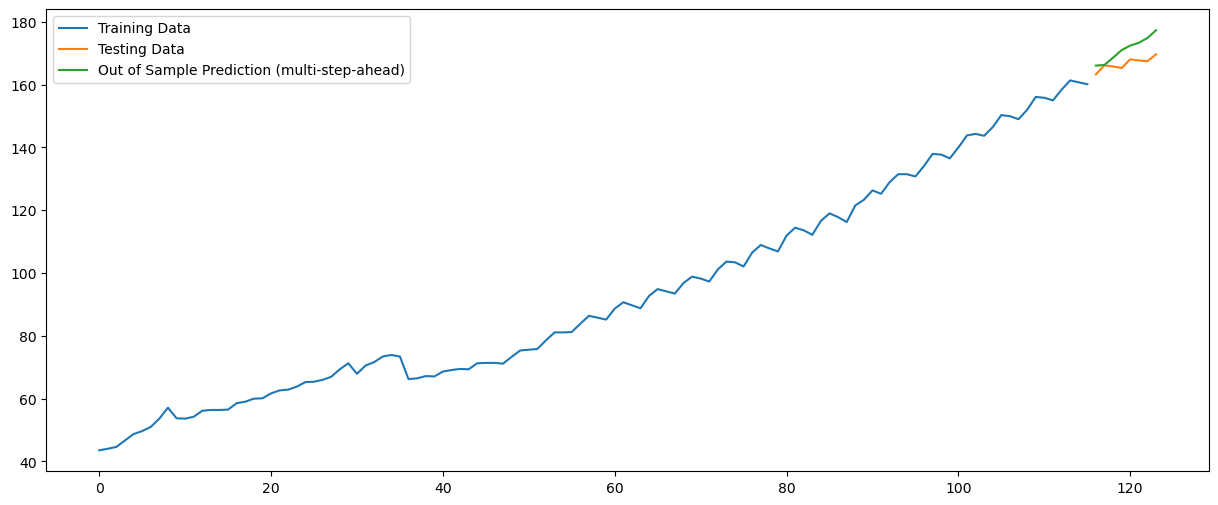

Dynamic Forecast MSE: 0.0162


In [38]:
#Dynamical Prediction
dynamic_prediction = np.copy(ts_train_scaled[-time_window:])

for i in range(len(ts_validation_scaled)):
    last_feature = np.reshape(dynamic_prediction[i:i+time_window], (1, time_window, 1))
    next_pred = model_ffnn.predict(last_feature)
    dynamic_prediction = np.append(dynamic_prediction, next_pred)

# Transform forecast values to original scale
dynamic_prediction = dynamic_prediction.reshape(-1, 1)
dynamic_prediction_original_scale = fitted_transformer.inverse_transform(dynamic_prediction)

# Plot
test_index = np.arange(len(ts_train_scaled), len(ts_train_scaled) + len(ts_validation_scaled))

plt.figure(figsize=(15, 6))
plt.plot(ts_train_not_scaled, label='Training Data')
plt.plot(test_index, ts_validation_not_scaled, label='Testing Data')
plt.plot(test_index, dynamic_prediction_original_scale[time_window:], label='Out of Sample Prediction (multi-step-ahead)')
plt.legend(loc="upper left")
plt.show()
# Compute MSE score on test data
test_mse = mean_squared_error(Ytest, dynamic_prediction[:len(Ytest)])
print('Dynamic Forecast MSE: {0:.4f}'.format(test_mse))